In [2]:
import geopandas as gpd
import pandas as pd
import ast #can make use of ast.literal_eval(string_rep_of_list) to convert string repr of list to actual list object
from shapely.geometry import Point
import folium
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt #to find centroid of a polygon

In [3]:
final_preproc_rental = pd.read_csv('../data/curated/Final_Preprocessed_Scraped_Rental.csv').drop(columns=['Unnamed: 0'])
vic_sf = gpd.read_file('../data/raw/vic_shapefile_zipped.zip')

# First, preprocess the victoria shapefile

In [4]:
def preproc_shapefile(vic_shapefile):
    
    #casefold into lower cases 
    vic_shapefile['LOC_NAME'] = vic_shapefile['LOC_NAME'].str.lower()
    
    #fix up some suburb names
    final_preproc_rental.loc[final_preproc_rental['suburb'] == 'prahran east','suburb'] = 'prahran'
    final_preproc_rental.loc[final_preproc_rental['suburb'] == 'preston west','suburb'] = 'preston'
    final_preproc_rental.loc[final_preproc_rental['suburb'] == 'sanctuary lakes','suburb'] = 'point cook'
    
    #remove duplicates
    vic_shapefile_no_duplicates = vic_shapefile.loc[vic_shapefile['LOC_NAME'].drop_duplicates().index,:]
    
    vic_shapefile['centroid'] = vic_shapefile['geometry'].map(
    lambda polygon: 
        wkt.loads( #after finding centroid, need to re-parse this back into a Point object
            wkt.loads(str(polygon)).centroid.wkt #need str object to find centroid
        )
    )
    
    return vic_shapefile
    
    

In [5]:
vic_shapefile_no_duplicates = preproc_shapefile(vic_sf)

# Helper function to plot geospatial heatmap (just for ONE variable!)

In [6]:
def geopandas_plotting(rental_df, 
                       sf, 
                       legend_name='Distribution of prices across suburbs', 
                       col_to_be_plot='cost_text',
                       save=False,
                       saved_map_name='',
                       map_format='html'):
    
    """
    Helper function to plot an aggregated metric by suburb
    (e.g. taking the mean of rental prices per suburb)
    
    Arguments:
    1. rental_df: df containing suburb columns and an aggregated
    metric corresponding to each suburb 
    
    E.g. columns may look like SUBURB || MEAN OF RENTAL PRICES
    
    2. sf: preprocessed victoria shapefile using the function above
    
    3. legend_name: legend text to appear on bottom right of the folium map
    
    4. col_to_be_plot: which numeric col to be plotted 
    
    
    """
    
    
    #if not specifying the legend name then the default one 
    #here will be used. 
    if not legend_name:
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'

    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting
    
    

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_df.merge(sf[['LOC_NAME', 'geometry']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()


    # df_toplot = rental_df.copy()
    # df_toplot = df_toplot \
    # .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    # .drop('LocationID', axis=1) #drop duplicate LocationID column

    # print(df_toplot)

    m = folium.Map(location=[-37.7829335, 144.9575056])

    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=legend_name
    )

    c.add_to(m)


    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{map_format}')


# Helper function to geospatial heatmap on a variable, PLUS the addition of 2nd variable via the markers.
- second variable can either be ordinal or continuous.

In [54]:
def geopandas_plotting_try_marker_with_second_var(rental_df, 
                                  sf, 
                                  second_variable,
                                  legend_name='Distribution of prices across suburbs', 
                                  col_to_be_plot='cost_text',
                                  SCALE_RADIUS=1,
                                  SCALE_WEIGHT=1,
                                  WANT_CONSTANT_RADIUS=True,
                                  save=False,
                                  saved_map_name='',
                                  saved_map_format='html'):
    
    """
    Plot mean rental price per suburb against a second variable, 
    for which magnitude is indicated via the radius and/or weights
    of the circle markers. 
    
    Some "tradeoffs" for testing the readability of the markers:
    
    1. Can either keep radius constant (just scale them), and 
    include the contribution of the 2nd variable via the weights. 
    Too much of weight --> indistinguishable magnitude, 
    Too little of weight --> Unreadable magnitude
    
    2. If values of 2nd variable not too big, then we can use
    non-constant radius: it will be determined by the values 
    of the 2nd variable. 
    - Risk: too much overlapping markers 
    
    feel free to experiment on this.
    
    
    """
    
    
    
    #if not specifying the legend name then the default one 
    #here will be used. 
    if not legend_name: 
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'
    

    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting
    

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_df.merge(sf[['LOC_NAME', 'geometry', 'centroid']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    #display(gdf)
    
    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()


    m = folium.Map(location=[-37.7829335, 144.9575056])
    

    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=legend_name
    )
   
    
    c.add_to(m)
    
    #typecast second_variable (which is ordinal) into 
    #float. Else if numpy int --> not recognizable 
    #--> throws error (int64 is not JSON serializable or whatever)
    gdf[second_variable] = gdf[second_variable].astype('float')
    
    
    
    #AN ATTEMPT TO ADD MARKERS: use CircleMarker
    
    for i in range(0, gdf.shape[0]):
        
        one_suburb = gdf.iloc[i,:]
        
        lat = one_suburb['centroid'].y
        lon = one_suburb['centroid'].x
        
        #if we want to scale radius for all suburbs, or
        #do we want it to vary based on the value of second var
        
        if WANT_CONSTANT_RADIUS == True:
            RADIUS = SCALE_RADIUS
        else:
            RADIUS = SCALE_RADIUS * one_suburb[second_variable]
        
        #
        WEIGHT = one_suburb[second_variable]*SCALE_WEIGHT
        
        actual_price = f'${round(np.exp(one_suburb[col_to_be_plot]), 2)}'
        
        actual_price += ', ' + one_suburb['suburb'].title()
        
        marker = folium.CircleMarker(
                location=[lat,lon],
                radius = RADIUS,
                popup=actual_price,
                color="#3186cc",
                fill=True,
                fill_color="grey",
                #opacity? less values --> less transparent
                #to increase border color and decrease fill color,
                #increase radius and decrease weight
                weight = WEIGHT
            )
        
        marker.add_to(m)
        
    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{saved_map_format}')
    


# Helper functions to prepare for geospatial modelling

Include second variable, with binning

In [8]:
def modify_rental_df_for_geovisual_incl_second_var(final_preproc_rental, 
                                           PARTITIONS,
                                           second_num_var,
                                           need_log_for_rental=True):
    
    """This function aims to prepare a dataframe for geospatial plotting, 
    consisting of: 
    1. mean rental price grouped by suburb, 
    
    2. AND the mean of another variable grouped by suburb.  
        - However, these means will be binned into ordinal variables, based on the cutoffs
            signified by PARTITIONS (excl. endpoints) , which is a list of numbers indicating
            (arbitrary..) boundaries from second_num_var assessed from the full dataset.
            
    The outputted df will have columns:
    
    index || suburb || cost_text || second_num_var || second_num_var_category
    
    """
    
    #for each suburb, calculate:
    #1. mean of rental price, and 
    #2. mean of the second numerical variable
    mean_cost_text_and_mean_second_var_per_sub =\
            final_preproc_rental.groupby('suburb').agg({'cost_text':'mean', second_num_var:'mean'})
    
    
    #define the endpoints of the partitions
    PARTITIONS_W_ENDPOINTS = [final_preproc_rental[second_num_var].min()] +\
                 PARTITIONS +\
                 [final_preproc_rental[second_num_var].max()]
    
    #map each of mean second numeric variable  
    #to its respective categories
    
    mean_2nd_var_per_suburb_categs = pd.cut(
        mean_cost_text_and_mean_second_var_per_sub[second_num_var], 
        PARTITIONS_W_ENDPOINTS,
        include_lowest=True
      )
    
    #Now the categories are still of type Category. 
    #Would be nice to map them into ordinal variables instead (ints)
    #since each category is still of Category data type, would be nice if we 
    #make it an ordinal variable
    
    NUM_CATEGS_TRAIN_DIST = mean_2nd_var_per_suburb_categs.nunique()
    
    CATEGS_OF_2ND_VAR_TO_ORDINAL_LOOOKUP =\
        dict(
            zip(
                mean_2nd_var_per_suburb_categs.unique().sort_values(),
                 range(1,NUM_CATEGS_TRAIN_DIST+1)
            )
        )
    
    #map the categories to ordinal variables (integers)
    
    second_num_categorized_colname = f'{second_num_var}_category'
    
    mean_cost_text_and_mean_second_var_per_sub[second_num_categorized_colname] =\
        mean_2nd_var_per_suburb_categs.map(
            lambda category: CATEGS_OF_2ND_VAR_TO_ORDINAL_LOOOKUP[category])
    
    #if need to display rental price in log scale
    if need_log_for_rental == True:
        mean_cost_text_and_mean_second_var_per_sub['cost_text'] = \
            np.log(mean_cost_text_and_mean_second_var_per_sub['cost_text'])
    
    #now mean_cost_text_and_mean_second_var_per_sub is ready for plotting!
    return mean_cost_text_and_mean_second_var_per_sub.reset_index()
    
    
    

If we want to include 2nd variable, but without binning it

In [9]:
def modify_rental_df_for_geovisual_incl_second_var_no_binning(final_preproc_rental, 
                                           second_num_var,
                                           normalize_second_var=False,
                                           need_log_for_rental=True,
                                           need_log_second_var=False):
    
    """This function aims to prepare a dataframe for geospatial plotting, 
    consisting of: 
    1. mean rental price grouped by suburb, 
    
    2. AND the mean of another variable grouped by suburb.  
            
    The outputted df will have columns:
    
    index || suburb || cost_text || second_num_var 
    
    """
    
    #for each suburb, calculate:
    #1. mean of rental price, and 
    #2. mean of the second numerical variable
    mean_cost_text_and_mean_second_var_per_sub =\
            final_preproc_rental.groupby('suburb').agg({'cost_text':'mean', second_num_var:'mean'})
    
    
    if need_log_second_var == True:
        mean_cost_text_and_mean_second_var_per_sub[second_num_var] =\
            np.log(mean_cost_text_and_mean_second_var_per_sub[second_num_var])
    
    
    #maybe we can make the mean of second_num_var across all suburbs to be normalized
    #to a 0-1 range so that in the geopandas plot the sizes would be 'comparable'.
    #currently I use the min-max scaler for the normalization method. 
    
    if normalize_second_var == True:
        
        #obtain metrics needed for min-max scaler
        max_second_num_var = mean_cost_text_and_mean_second_var_per_sub[second_num_var].max()
        min_second_num_var = mean_cost_text_and_mean_second_var_per_sub[second_num_var].min()
        
        diff_max_min_min_second_num_var = max_second_num_var - min_second_num_var
        
        #now, we do the scaling
        mean_cost_text_and_mean_second_var_per_sub[second_num_var] =\
            mean_cost_text_and_mean_second_var_per_sub[second_num_var].\
                    map(lambda x: 
                        (x - min_second_num_var)/diff_max_min_min_second_num_var
                       )
        
    
    #if need to display rental price in log scale
    if need_log_for_rental == True:
        mean_cost_text_and_mean_second_var_per_sub['cost_text'] = \
            np.log(mean_cost_text_and_mean_second_var_per_sub['cost_text'])
    
    #now mean_cost_text_and_mean_second_var_per_sub is ready for plotting!
    return mean_cost_text_and_mean_second_var_per_sub.reset_index()
    
    
    

# P1: Plot (log-scale) median rental price

In [24]:
log_mean_rental_price_per_suburb = final_preproc_rental.groupby('suburb')['cost_text'].mean().reset_index()
log_mean_rental_price_per_suburb['cost_text'] = np.log(log_mean_rental_price_per_suburb['cost_text'])

mean_rental_price_per_suburb = log_mean_rental_price_per_suburb.copy()
mean_rental_price_per_suburb['cost_text'] = np.exp(log_mean_rental_price_per_suburb['cost_text'])

In [28]:
geopandas_plotting(
    mean_rental_price_per_suburb, 
    vic_shapefile_no_duplicates, 
    legend_name='Distribution of prices across suburbs (log-scale)', 
    col_to_be_plot='cost_text',
    save=True,
    saved_map_name='log_mean_rental_no_outlier',
    map_format='html'
)

In [29]:
geopandas_plotting(
    log_mean_rental_price_per_suburb, 
    vic_shapefile_no_duplicates, 
    legend_name='Distribution of prices across suburbs (log-scale)', 
    col_to_be_plot='cost_text',
    save=True,
    saved_map_name='log_mean_rental_no_outlier',
    map_format='html'
)

# P2: Plot (log-scale) mean against (ordinal) nearest train station

Why have I managed to find categories for nearest train station? Here's a (albeit arbitrary) justification from the whole distribution of nearest train station:

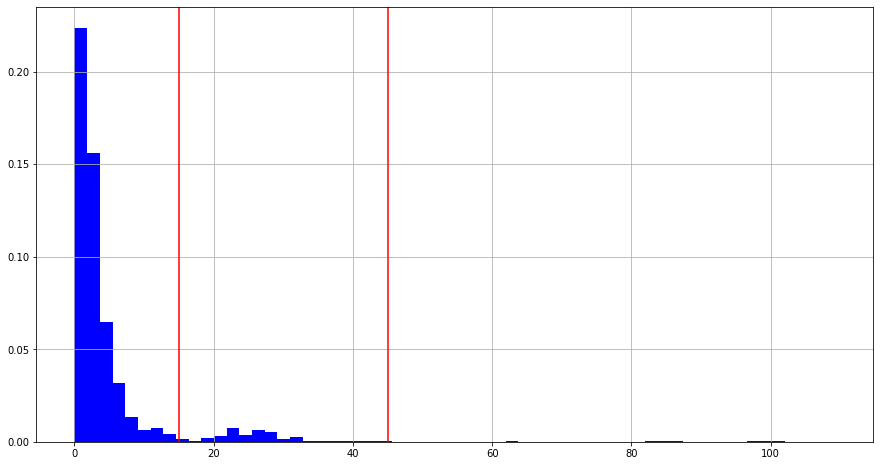

In [11]:
final_preproc_rental['nearest_train_station'].hist(bins=60, 
                                                   figsize=(15,8), 
                                                   density=True,
                                                   color='b')

#it seems that we can (still, arbitrarily) partition the distribution into 3 clusters

LOW_V_MEDIUM_TRAIN_DISTANCE = 15
MEDIUM_V_HIGH_TRAIN_DISTANCE = 45


plt.axvline(x=LOW_V_MEDIUM_TRAIN_DISTANCE, color='r') #"low"
plt.axvline(x=MEDIUM_V_HIGH_TRAIN_DISTANCE, color='r') #"medium"


In [14]:
mean_cost_text_vs_categorical_mean_train_dist = modify_rental_df_for_geovisual_incl_second_var(
    final_preproc_rental, 
    [LOW_V_MEDIUM_TRAIN_DISTANCE, MEDIUM_V_HIGH_TRAIN_DISTANCE],
    'nearest_train_station')

In [94]:
help(geopandas_plotting_try_marker_with_second_var)

Help on function geopandas_plotting_try_marker_with_second_var in module __main__:

geopandas_plotting_try_marker_with_second_var(rental_df, sf, second_variable, legend_name='Distribution of prices across suburbs', col_to_be_plot='cost_text', SCALE_RADIUS=1, SCALE_WEIGHT=1, WANT_CONSTANT_RADIUS=True, save=False, saved_map_name='', saved_map_format='html')



uncomment these chunks of code to plot

In [57]:
geopandas_plotting_try_marker_with_second_var(
    mean_cost_text_vs_categorical_mean_train_dist, 
    vic_shapefile_no_duplicates, 
    'nearest_train_station_category',
    legend_name='Distribution of prices across suburbs', 
    col_to_be_plot='cost_text',
    SCALE_RADIUS=8,
    SCALE_WEIGHT=7,
    save=False,
    WANT_CONSTANT_RADIUS=False,
    saved_map_name='log_mean_rental_no_outlier_w_categ_train_dist',
    saved_map_format='html'
)

# P3: Plot (log-scale) mean against (ordinal) nearest hospital

A bit of justification on why I can "categorize" nearest hospital into 5 clusters

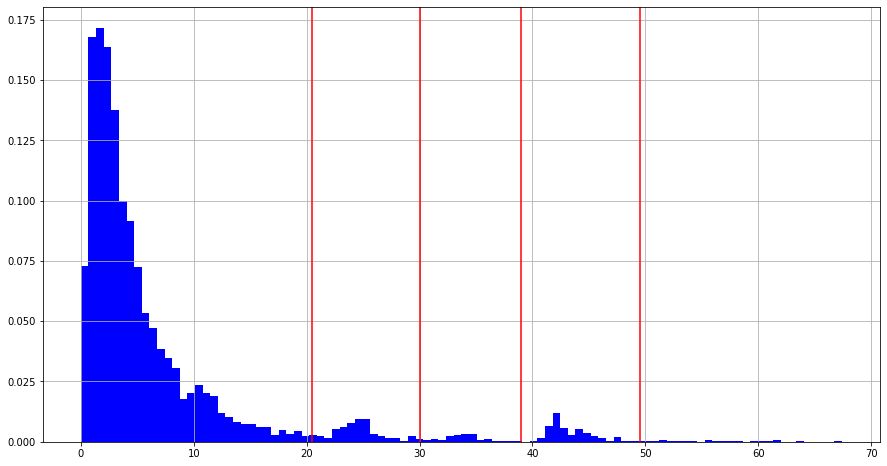

In [29]:
final_preproc_rental['nearest_hospital'].hist(bins=100, figsize=(15,8), 
                                              density=True,
                                             color='b')

#it seems that we can (still, arbitrarily) partition the distribution into 5 clusters

PARTITION_1_HOSPITAL_DISTANCE = 20.5
PARTITION_2_HOSPITAL_DISTANCE = 30
PARTITION_3_HOSPITAL_DISTANCE = 39
PARTITION_4_HOSPITAL_DISTANCE = 49.5

plt.axvline(x=PARTITION_1_HOSPITAL_DISTANCE, color='r') 
plt.axvline(x=PARTITION_2_HOSPITAL_DISTANCE, color='r') 
plt.axvline(x=PARTITION_3_HOSPITAL_DISTANCE, color='r') 
plt.axvline(x=PARTITION_4_HOSPITAL_DISTANCE, color='r') 



In [30]:
mean_cost_text_vs_categorical_mean_hospital_dist = modify_rental_df_for_geovisual_incl_second_var(
    final_preproc_rental, 
    [PARTITION_1_HOSPITAL_DISTANCE,
     PARTITION_2_HOSPITAL_DISTANCE,
     PARTITION_3_HOSPITAL_DISTANCE,
     PARTITION_4_HOSPITAL_DISTANCE],
    'nearest_hospital'
)

In [31]:
help(geopandas_plotting_try_marker_with_second_var)

Help on function geopandas_plotting_try_marker_with_second_var in module __main__:

geopandas_plotting_try_marker_with_second_var(rental_df, sf, second_variable, legend_name='Distribution of prices across suburbs', col_to_be_plot='cost_text', SCALE_RADIUS=1, SCALE_WEIGHT=1, WANT_CONSTANT_RADIUS=True, save=False, saved_map_name='', saved_map_format='html')
    Plot mean rental price per suburb against a second variable, 
    for which magnitude is indicated via the radius and/or weights
    of the circle markers. 
    
    Some "tradeoffs" for testing the readability of the markers:
    
    1. Can either keep radius constant (just scale them), and 
    include the contribution of the 2nd variable via the weights. 
    Too much of weight --> indistinguishable magnitude, 
    Too little of weight --> Unreadable magnitude
    
    2. If values of 2nd variable not too big, then we can use
    non-constant radius: it will be determined by the values 
    of the 2nd variable. 
    - Risk: to

uncomment these chunks of code to plot

In [35]:
geopandas_plotting_try_marker_with_second_var(
    mean_cost_text_vs_categorical_mean_hospital_dist, 
    vic_shapefile_no_duplicates, 
    'nearest_hospital_category',
    legend_name='Distribution of prices across suburbs', 
    col_to_be_plot='cost_text',
    SCALE_RADIUS=5,
    SCALE_WEIGHT=2.2,
    save=True,
    WANT_CONSTANT_RADIUS=False,
    saved_map_name='log_mean_rental_no_outlier_w_categ_hospital_dist',
    saved_map_format='html'
)

# P4: plot (log-scale) mean against log mean nearest school

In [56]:
col = 'nearest_school'

geopandas_plotting_try_marker_with_second_var(
    
    modify_rental_df_for_geovisual_incl_second_var_no_binning(
                                           final_preproc_rental, 
                                           col,
                                           normalize_second_var=False,
                                           need_log_for_rental=True,
                                           need_log_second_var=True
    ), 
    vic_shapefile_no_duplicates, 
      col,
      legend_name='Distribution of prices across suburbs', 
      col_to_be_plot='cost_text',
      SCALE_RADIUS=11,
      SCALE_WEIGHT=3,
      WANT_CONSTANT_RADIUS=True,
      save=True,
      saved_map_name='log_mean_rental_no_outlier_w_log_nearest_school'
)

# P5: plot (log-scale) mean against log mean distance to cbd
(probably not as informative as the others because we know roughly where the CBD is)

In [131]:
uncomment these chunks of code to plot

col = 'distance_to_cbd'

geopandas_plotting_try_marker_with_second_var(
    
    modify_rental_df_for_geovisual_incl_second_var_no_binning(
                                           final_preproc_rental, 
                                           col,
                                           normalize_second_var=False,
                                           need_log_for_rental=True,
                                           need_log_second_var=True
    ), 
    vic_shapefile_no_duplicates, 
      col,
      legend_name='Distribution of prices across suburbs', 
      col_to_be_plot='cost_text',
      SCALE_RADIUS=11,
      SCALE_WEIGHT=2,
      WANT_CONSTANT_RADIUS=True,
      save=False,
      saved_map_name='log_mean_rental_no_outlier_w_log_dist_to_cbd'
)